<h1><span style="color: #169179;"><strong>DataSet OMS.</strong></span></h1>

<p style="text-align: justify;">La OMS estima que cada a&ntilde;o se producen 12 millones de muertes en todo el mundo debido a enfermedades card&iacute;acas, producidas en su gran mayor&iacute;a por enfermedades cardiovasculares. El pron&oacute;stico temprano de las enfermedades cardiovasculares puede<br />ayudar en la toma de decisiones sobre cambios en el estilo de vida en pacientes de alto riesgo y reducir las complicaciones. La&nbsp;base&nbsp; de datos cardio.csv contiene mediciones realizadas a pacientes hace 10 a&ntilde;os, entre los cuales se encuentran</p>
<p>● Sex: M - F<br />● Age: edad<br />● Education: codificada, considerando que un valor m&aacute;s alto corresponde a un mayor<br />nivel educativo.<br />● currentSmoker: si el paciente es o no fumador actual<br />● cigsPerDay: el n&uacute;mero de cigarrillos que la persona fumaba en promedio en un d&iacute;a.<br />● BPMeds: si el paciente estaba tomando medicamentos para la presi&oacute;n arterial (0: No,<br />1: S&iacute;)<br />● prevalenStroke: si el paciente hab&iacute;a tenido un accidente cerebrovascular previamente<br />(0: No, 1: S&iacute;)<br />● prevalentHyp:: si el paciente era hipertenso o no (0: No, 1: S&iacute;)<br />● diabetes: si el paciente ten&iacute;a diabetes o no (0: No, 1: S&iacute;)<br />● totChol: nivel de colesterol total<br />● sysBP: presi&oacute;n arterial sist&oacute;lica<br />● diaBP_BMI: presi&oacute;n arterial diast&oacute;lica<br />● BMI: &Iacute;ndice de masa corporal<br />● heartRate: : ritmo card&iacute;aco<br />● glucose: nivel de glucosa<br />● TenYearCHD: se indica si el paciente sufri&oacute; o no una enfermedad coronaria en los<br />&uacute;ltimos 10 a&ntilde;os.(0: No, 1: S&iacute;)</p>

<p><strong>Objetivo:</strong> Tratar de predecir, mediante las variables anteriores, si el sujeto es Hombre o Mujer, ver si hay diferencia significativa entre ambos.&nbsp;</p>

## Imports

In [1]:
# Importamos todas las librerias necesarias en el documento.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score


## Funciones auxiliares

In [2]:
#Funcion para convertir columnas categoricas a numericas eliminando la primera para evitar la Multicoli...
def aplicar_get_dummies(df, columnas_categoricas):
   
    df_copia = df.copy()
    
    # Obtener variables dummy solo de las columnas especificadas
    dummies = pd.get_dummies(df_copia[columnas_categoricas], drop_first=True)
    
    # Eliminar columnas categóricas originales
    df_copia.drop(columns=columnas_categoricas, inplace=True)
    
    # Concatenar el DataFrame original (sin categóricas) con los dummies
    df_modificado = pd.concat([df_copia, dummies], axis=1)
    
    return df_modificado

In [3]:
def reemplazar_outliers(df, columnas, estrategia='median'):
    df = df.copy()
    
    for col in columnas:
        if col not in df.columns:
            print(f"La columna '{col}' no está en el DataFrame. Se omite.")
            continue
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"La columna '{col}' no es numérica. Se omite.")
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Definir el valor de reemplazo según la estrategia
        if estrategia == 'median':
            valor = df[col].median()
        elif estrategia == 'mean':
            valor = df[col].mean()
        elif estrategia == 'most_frequent':
            valor = df[col].mode()[0]
        else:
            raise ValueError("La estrategia debe ser 'median', 'mean' o 'most_frequent'.")

        # Reemplazar outliers
        df.loc[(df[col] < limite_inferior) | (df[col] > limite_superior), col] = valor

    return df

In [4]:
# Funciones para eliminar outliers
def remove_outliers(df, columns):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

In [5]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [6]:
from sklearn.preprocessing import StandardScaler

def normalizar_columnas(df, columnas_a_normalizar):
    
    df_copia = df.copy()
    scaler = StandardScaler()
    df_copia[columnas_a_normalizar] = scaler.fit_transform(df_copia[columnas_a_normalizar])
    return df_copia


In [7]:
#Resumen de valores nulos
def resumen_valores_nulos(data):
    nulos = data.isnull().sum()[data.isnull().any()]
    porcentaje = (nulos / len(data)) * 100

    resumen_nulos = pd.DataFrame({
        'Valores Nulos': nulos,
        'Porcentaje (%)': porcentaje.round(2)
    })
    return resumen_nulos

# Extraccion

In [8]:
# Cargar datos
data = pd.read_csv('cardio.csv')
data

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,M,39,4.0,No,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,F,46,2.0,No,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,M,48,1.0,Yes,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,F,61,3.0,Yes,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,F,46,3.0,Yes,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,M,50,1.0,Yes,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,M,51,3.0,Yes,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,F,48,2.0,Yes,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,F,44,1.0,Yes,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


In [9]:
# Información general
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              4238 non-null   object 
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   object 
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 529.9+ KB


# Transformacion

In [10]:
resumen_nulos = resumen_valores_nulos(data)
resumen_nulos

,Valores Nulos,Porcentaje (%)
education,105,2.48
cigsPerDay,29,0.68
BPMeds,53,1.25
totChol,50,1.18
BMI,19,0.45
heartRate,1,0.02
glucose,388,9.16


In [11]:
# Creamos una copia independiente del DF
data = data.copy()  

In [12]:
# Reemplazamos los valores nulos
data = data.fillna(data.median(numeric_only=True))

In [13]:
# Transformamos Variables categoricas con Get_dummies
columnas_categoricas = ["currentSmoker"]
data_clean = aplicar_get_dummies(data, columnas_categoricas).copy()

In [14]:
# Verificamos las columnas nuevamente
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                4238 non-null   object 
 1   age                4238 non-null   int64  
 2   education          4238 non-null   float64
 3   cigsPerDay         4238 non-null   float64
 4   BPMeds             4238 non-null   float64
 5   prevalentStroke    4238 non-null   int64  
 6   prevalentHyp       4238 non-null   int64  
 7   diabetes           4238 non-null   int64  
 8   totChol            4238 non-null   float64
 9   sysBP              4238 non-null   float64
 10  diaBP              4238 non-null   float64
 11  BMI                4238 non-null   float64
 12  heartRate          4238 non-null   float64
 13  glucose            4238 non-null   float64
 14  TenYearCHD         4238 non-null   int64  
 15  currentSmoker_Yes  4238 non-null   bool   
dtypes: bool(1), float64(9), 

In [15]:
# Outliers: Para este caso eliminamos Reemplazamos los Outliers
numeric_columns =['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']
data_no_outliers = reemplazar_outliers(data_clean, numeric_columns)
print(f"Datos restantes luego de sustituir outliers: {data_no_outliers.shape}")

Datos restantes luego de sustituir outliers: (4238, 16)


In [16]:
#Normalizamos las columnas: Uso StandardScaler que es muy sensible a los outliers
dana_no_outliers = normalizar_columnas(data_no_outliers, numeric_columns)
data_no_outliers

,sex,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,currentSmoker_Yes
0,M,39,4.0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,False
1,F,46,2.0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,False
2,M,48,1.0,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,True
3,F,61,3.0,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1,True
4,F,46,3.0,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,M,50,1.0,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1,True
4234,M,51,3.0,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0,True
4235,F,48,2.0,20.0,0.0,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0,True
4236,F,44,1.0,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,78.0,0,True


##  División del conjunto de datos

In [17]:
train_set, val_set, test_set = train_val_test_split(data_no_outliers)

In [18]:
X_train = train_set.drop('sex', axis=1)
y_train = train_set['sex'].copy()

X_val = val_set.drop('sex', axis=1)
y_val = val_set['sex'].copy()

X_test = test_set.drop('sex', axis=1)
y_test = test_set['sex'].copy()

## 1. Regresion Logistica

In [19]:
# Modelo De regresion logistica
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [20]:
# Predicciones
y_pred = log_reg.predict(X_val)



              precision    recall  f1-score   support

           F       0.66      0.86      0.74       467
           M       0.72      0.46      0.56       381

    accuracy                           0.68       848
   macro avg       0.69      0.66      0.65       848
weighted avg       0.69      0.68      0.66       848



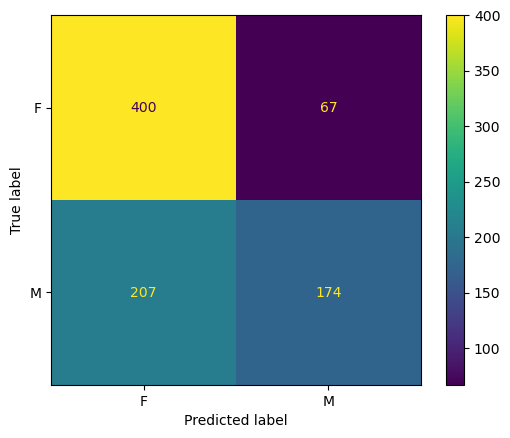

In [21]:
# Evaluación
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(log_reg, X_val, y_val, values_format='d')
print("\n")
print(classification_report(y_val, y_pred))

## 2. SMV: Kernel lineal

In [22]:
from sklearn.svm import SVC
# SVM Large Margin Classification Creacion del modelo
svm_linear = SVC(kernel="linear", C=50, probability=True)
svm_linear.fit(X_train, y_train)

SVC(C=50, kernel='linear', probability=True)

In [23]:
#Hacemos las predicciones sonbre el conjunto evaluacion para probar que tan bien funciona
y_pred = svm_linear.predict(X_val)

              precision    recall  f1-score   support

           F       0.66      0.87      0.75       467
           M       0.73      0.45      0.56       381

    accuracy                           0.68       848
   macro avg       0.70      0.66      0.65       848
weighted avg       0.69      0.68      0.66       848



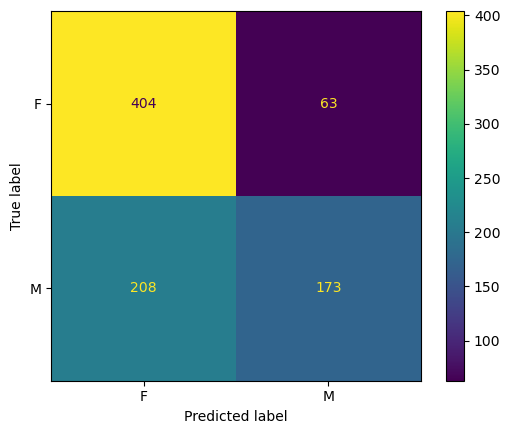

In [24]:
#Evaluamos los modelos
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator( svm_linear, X_val, y_val, values_format='d')
print(classification_report(y_val, y_pred))

## 3. SMV: Gaussian Kernel

In [25]:
#Creamos el modelo 
rbf_kernel = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.5, C=1000, probability=True))
        ])
rbf_kernel.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.5, probability=True))])

In [26]:
#Hacemos las predicciones para evaluar el modelo
y_pred = rbf_kernel.predict(X_val)

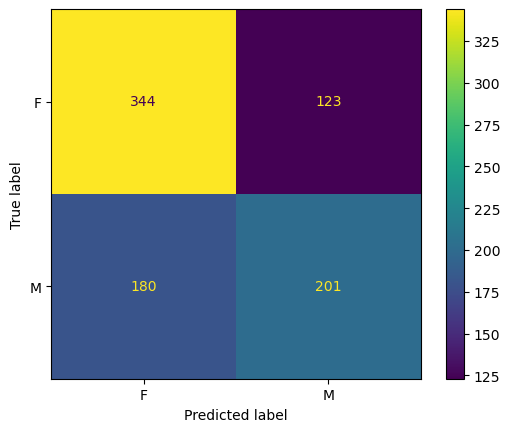

In [27]:
#Evaluamos el modelo
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rbf_kernel, X_val, y_val, values_format='d')

In [28]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           F       0.66      0.74      0.69       467
           M       0.62      0.53      0.57       381

    accuracy                           0.64       848
   macro avg       0.64      0.63      0.63       848
weighted avg       0.64      0.64      0.64       848



## 4. SMV:Polynomial Kernel ()

In [29]:
#Crear Modelo Polinomial
svm_poly = SVC(kernel="poly", degree=3, coef0=10, C=20, probability=True)
svm_poly.fit(X_train, y_train)

SVC(C=20, coef0=10, kernel='poly', probability=True)

In [30]:
#Hacemos las predicciones para evaluar el modelo
y_pred = svm_poly.predict(X_val)

              precision    recall  f1-score   support

           F       0.66      0.88      0.75       467
           M       0.75      0.43      0.55       381

    accuracy                           0.68       848
   macro avg       0.70      0.66      0.65       848
weighted avg       0.70      0.68      0.66       848



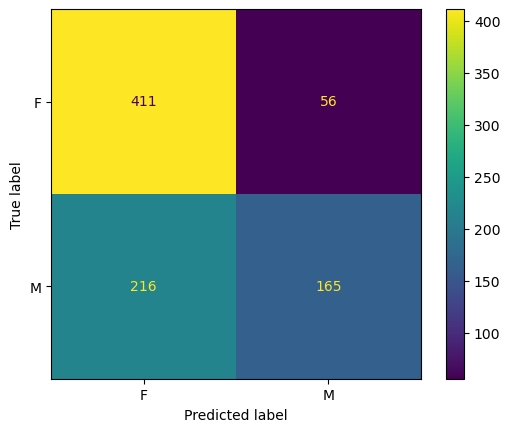

In [31]:
#Evaluamos el modelo
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator( svm_poly, X_val, y_val, values_format='d')
print(classification_report(y_val, y_pred))

### Comparación de Modelos

<p><strong>Comparaci&oacute;n de Modelos:</strong> Para la comparaci&oacute;n del modelo lo hacemos sobre el &uacute;ltimo conjunto de nuestra partici&oacute;n de muestra que es X_test.</p>

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

modelos = {
    "Regresión Logística": log_reg,
    "SVM Lineal": svm_linear,
    "SVM Gaussiano": rbf_kernel,
    "SVM Polinomial": svm_poly
}

# Evaluar cada modelo
resultados = {}

for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    
    # Verificar si el modelo tiene predict_proba (necesario para ROC AUC)
    try:
        y_scores = modelo.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_scores)
    except AttributeError:
        roc = "N/A"
    
    # Evaluar las métricas con pos_label='M' (para la clase positiva "M")
    resultados[nombre] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label='M'),
        "Recall": recall_score(y_test, y_pred, pos_label='M'),
        "F1 Score": f1_score(y_test, y_pred, pos_label='M'),
        "ROC AUC": roc
    }




In [33]:
# Mostrar los resultados en un DataFrame
df_resultados = pd.DataFrame(resultados).T
df_resultados

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Regresión Logística,0.676887,0.671533,0.500000,0.573209,0.731686
SVM Lineal,0.666274,0.670683,0.453804,0.541329,0.723053
SVM Gaussiano,0.601415,0.542373,0.521739,0.531856,0.638123
SVM Polinomial,0.691038,0.713710,0.480978,0.574675,0.754028


<p><strong data-start="809" data-end="851">Conclusi&oacute;n:&nbsp;</strong></p>
<ul>
<li class="" data-start="806" data-end="999">
<p class="" data-start="809" data-end="851"><strong data-start="809" data-end="851">Mejor modelo general: <em data-start="833" data-end="849">SVM Polinomial</em></strong></p>
<ul data-start="855" data-end="999">
<li class="" data-start="855" data-end="928">
<p class="" data-start="857" data-end="928">Tiene el mayor accuracy, precision, F1 Score y ROC AUC.</p>
</li>
<li class="" data-start="932" data-end="999">
<p class="" data-start="934" data-end="999">Aunque su recall no es el m&aacute;s alto, sigue siendo competitivo.</p>
</li>
</ul>
</li>
<li class="" data-start="1001" data-end="1175">
<p class="" data-start="1004" data-end="1059"><strong data-start="1004" data-end="1058">Regresi&oacute;n Log&iacute;stica sigue siendo una opci&oacute;n s&oacute;lida</strong>:</p>
<ul data-start="1063" data-end="1175">
<li class="" data-start="1063" data-end="1104">
<p class="" data-start="1065" data-end="1104">Su rendimiento es bastante equilibrado.</p>
</li>
<li class="" data-start="1108" data-end="1175">
<p class="" data-start="1110" data-end="1175">Modelos m&aacute;s simples y r&aacute;pidos, puede ser preferible.</p>
</li>
</ul>
</li>
<li class="" data-start="1177" data-end="1318">
<p class="" data-start="1180" data-end="1220"><strong data-start="1180" data-end="1219">SVM Gaussiano rinde peor en general</strong>:</p>
<ul data-start="1224" data-end="1318">
<li class="" data-start="1224" data-end="1318">
<p class="" data-start="1226" data-end="1318">Tiene el peor accuracy y ROC AUC, indicando menor capacidad para discriminar clases.</p>
</li>
</ul>
</li>
<li class="" data-start="1320" data-end="1444">
<p class="" data-start="1323" data-end="1390"><strong data-start="1323" data-end="1389">SVM Lineal no aporta mejora clara sobre la regresi&oacute;n log&iacute;stica</strong>:</p>
<ul data-start="1394" data-end="1444">
<li class="" data-start="1394" data-end="1444">
<p class="" data-start="1396" data-end="1444">Similar precisi&oacute;n, pero menor recall y F1 Score.</p>
</li>
</ul>
</li>
</ul>
<p>Si el tiempo de entrenamiento y la complejidad del modelo no son un problema, el SVM con kernel polinomial &nbsp;mejor rendimiento.<br data-start="1624" data-end="1627" />Si necesitas un modelo m&aacute;s interpretable o eficiente, la regresi&oacute;n log&iacute;stica es una buena alternativa.</p>

## Mejorando Modelos que funcionan mejor.

### 1.2. Regresion Logistica

In [34]:
#Comparacion de modelos utilizando diferentes tipos de Penalizacion

# Diccionario con variantes de regresión logística
modelos = {
    'MLE (sin penalización)': LogisticRegression(penalty= None, max_iter=10000, random_state=42),
    'Ridge (L2)': LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=10000, random_state=42),
    'Lasso (L1)': LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=10000, random_state=42),
    'Elastic Net': LogisticRegression(penalty='elasticnet', C=1.0, solver='saga', l1_ratio=0.5,
                                      max_iter=10000, random_state=42)
}

# Evaluaremos cada modelo
resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_val)

    resultados.append({
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred, pos_label='M'),
        'Recall': recall_score(y_val, y_pred, pos_label='M'),
        'F1 Score': f1_score(y_val, y_pred, pos_label='M')
    })

# Mostrar resultados en un DataFrame ordenado por F1 Score
df_resultados = pd.DataFrame(resultados).sort_values(by='F1 Score', ascending=False)
df_resultados

,Modelo,Accuracy,Precision,Recall,F1 Score
0,MLE (sin penalización),0.676887,0.721992,0.456693,0.559486
1,Ridge (L2),0.676887,0.721992,0.456693,0.559486
2,Lasso (L1),0.670991,0.712500,0.448819,0.550725
3,Elastic Net,0.670991,0.712500,0.448819,0.550725


<p class="" data-start="622" data-end="899"><strong>Conclusi&oacute;n:</strong></p>
<p class="" data-start="622" data-end="899">De los modelos evaluados, la regresi&oacute;n log&iacute;stica MLE (sin penalizaci&oacute;n) y la regresi&oacute;n Ridge (L2) presentaron el mejor desempe&ntilde;o global, con una accuracy de 67.69%, precisi&oacute;n de 72.20%, y un F1 Score de 0.5595, superando a los modelos Lasso y Elastic Net.</p>
<p class="" data-start="905" data-end="1208">Dado que MLE y Ridge ofrecen resultados id&eacute;nticos, y Ridge incorpora regularizaci&oacute;n L2 que puede mejorar la generalizaci&oacute;n en presencia de multicolinealidad o datos ruidosos, se recomienda seleccionar Ridge (L2) como el modelo final por su robustez te&oacute;rica y rendimiento equivalente al mejor modelo.</p>

### Buscamos C optima para el Modelo de regresion Ridge

In [35]:
# Buscamos C optima
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score

# Definir la métrica de evaluación (en tu caso, F1 para clase 'M')
scorer = make_scorer(f1_score, pos_label='M')

# Definir el modelo base
modelo_base = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, random_state=42)

# Rango de C a probar
param_grid = {'C': np.logspace(-3, 2, 10)}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(estimator=modelo_base, param_grid=param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Mejor parámetro
print("Mejor valor de C:", grid_search.best_params_['C'])
print("Mejor F1 Score promedio en CV:", grid_search.best_score_)

Mejor valor de C: 0.5994842503189409
Mejor F1 Score promedio en CV: 0.5672593508703223


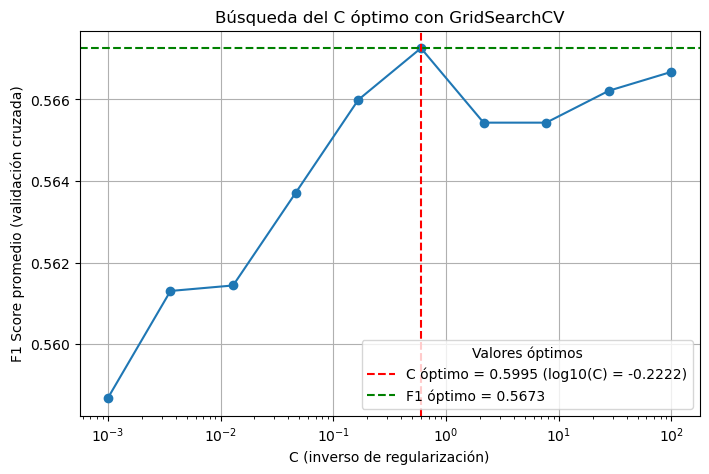

In [36]:
# Extraer todos los resultados
resultados = pd.DataFrame(grid_search.cv_results_)

# Mejor valor de C y F1 Score
C_optimo = grid_search.best_params_['C']
f1_optimo = grid_search.best_score_
log_C_optimo = np.log10(C_optimo)


# Graficar
plt.figure(figsize=(8, 5))
plt.semilogx(resultados['param_C'].astype(float), resultados['mean_test_score'], marker='o')

# Líneas guía
plt.axvline(x=C_optimo, color='red', linestyle='--', label=f'C óptimo = {C_optimo:.4f} (log10(C) = {log_C_optimo:.4f})')

plt.axhline(y=f1_optimo, color='green', linestyle='--', label=f'F1 óptimo = {f1_optimo:.4f}')

# Leyenda 
plt.legend(title='Valores óptimos', loc='best')
            
plt.xlabel('C (inverso de regularización)')
plt.ylabel('F1 Score promedio (validación cruzada)')
plt.title('Búsqueda del C óptimo con GridSearchCV')
plt.grid(True)
plt.show()

### Modelo Optimo Actual

In [37]:
# Definir el modelo final con el valor óptimo de C
modelo_final = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, C=.5994842503189409, random_state=42)
# Entrenar el modelo con los datos de entrenamiento
modelo_final.fit(X_train, y_train)

LogisticRegression(C=0.5994842503189409, max_iter=10000, random_state=42)

In [38]:
# Realizar predicciones en el conjunto de validación y prueba
y_val_pred = modelo_final.predict(X_val)
y_test_pred = modelo_final.predict(X_test)

In [39]:
df_val = pd.DataFrame(classification_report(y_val, y_val_pred, output_dict=True)).transpose()
df_test = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).transpose()

Reporte de clasificación - Validación
              precision  recall  f1-score  support
F                 0.659   0.857     0.745  467.000
M                 0.722   0.457     0.559  381.000
accuracy          0.677   0.677     0.677    0.677
macro avg         0.690   0.657     0.652  848.000
weighted avg      0.687   0.677     0.662  848.000

Reporte de clasificación - Prueba
              precision  recall  f1-score  support
F                 0.679   0.812     0.740  480.000
M                 0.672   0.500     0.573  368.000
accuracy          0.677   0.677     0.677    0.677
macro avg         0.675   0.656     0.657  848.000
weighted avg      0.676   0.677     0.668  848.000


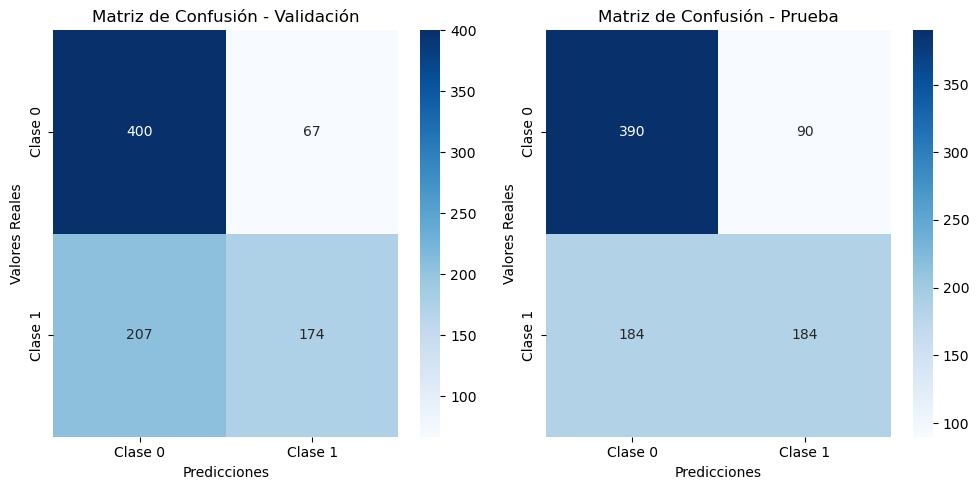

In [40]:
#Evaluacion del modelo

# Mostrar tablas con solo 3 decimales
print("Reporte de clasificación - Validación")
print(df_val.round(3))

print("\nReporte de clasificación - Prueba")
print(df_test.round(3))

# Matrices de confusión
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Mostrar las matrices de confusión
plt.figure(figsize=(10, 5))

# Matriz de confusión para validación
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión - Validación')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')

# Matriz de confusión para prueba
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')

plt.tight_layout()
plt.show()

<p class="" data-start="622" data-end="899"><strong>Conclusi&oacute;n:</strong></p>
<p>El modelo de regresi&oacute;n log&iacute;stica muestra un desempe&ntilde;o general estable y aceptable, con una exactitud del 67.7% tanto en validaci&oacute;n como en prueba. Su rendimiento es especialmente favorable para la clase Femenina (0), con altos valores de recall (superiores al 80%), lo que indica que identifica correctamente la mayor&iacute;a de los casos de esta clase.</p>
<p>Sin embargo, el modelo presenta dificultades importantes al clasificar la clase Masculina (1), con valores bajos de recall (entre 45% y 50%), lo que implica una elevada tasa de falsos negativos para esta clase. Este desequilibrio en el desempe&ntilde;o sugiere un sesgo del modelo hacia la clase F, posiblemente derivado de un desbalance en los datos o patrones menos diferenciados en la clase M.</p>
<p>Por tanto, se recomienda explorar t&eacute;cnicas de ajuste como el uso de class_weight='balanced', el ajuste del umbral de decisi&oacute;n o el uso de modelos m&aacute;s complejos, con el objetivo de mejorar la capacidad del modelo para identificar correctamente la clase Masculina (1) y lograr un rendimiento m&aacute;s equilibrado entre las clases.</p>

### Modelo Optimo Balanceando las clases

In [42]:
# Definir el modelo final con el valor óptimo de C
modelo_final = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, C=.5994842503189409, random_state=42, class_weight='balanced')
# Entrenar el modelo con los datos de entrenamiento
modelo_final.fit(X_train, y_train)

LogisticRegression(C=0.5994842503189409, class_weight='balanced',
                   max_iter=10000, random_state=42)

In [43]:
# Realizar predicciones en el conjunto de validación y prueba
y_val_pred = modelo_final.predict(X_val)
y_test_pred = modelo_final.predict(X_test)

#Evaluacion del modelo
df_val = pd.DataFrame(classification_report(y_val, y_val_pred, output_dict=True)).transpose()
df_test = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).transpose()


Reporte de clasificación - Validación
              precision  recall  f1-score  support
F                 0.697   0.764     0.729  467.000
M                 0.673   0.593     0.630  381.000
accuracy          0.688   0.688     0.688    0.688
macro avg         0.685   0.679     0.680  848.000
weighted avg      0.686   0.688     0.685  848.000

Reporte de clasificación - Prueba
              precision  recall  f1-score  support
F                 0.703   0.731     0.717  480.000
M                 0.630   0.598     0.614  368.000
accuracy          0.673   0.673     0.673    0.673
macro avg         0.667   0.665     0.665  848.000
weighted avg      0.672   0.673     0.672  848.000


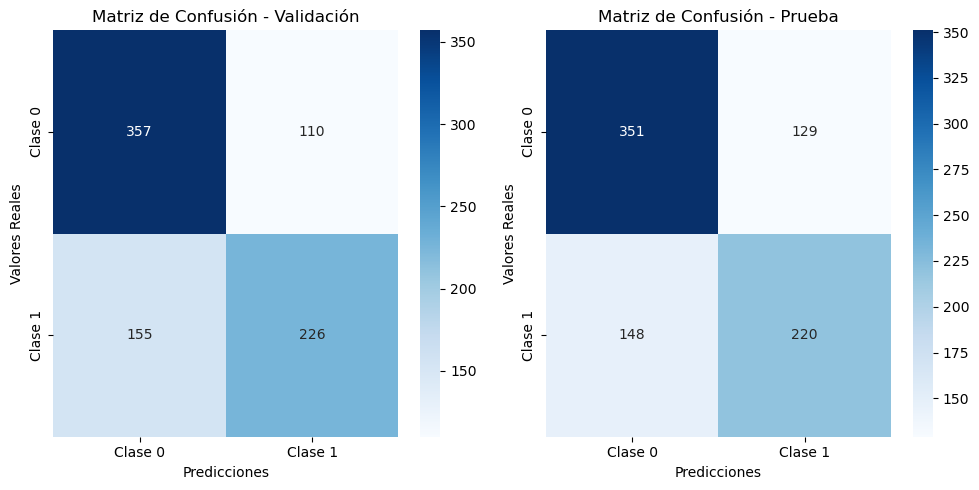

In [44]:
#Evaluacion

# Mostrar tablas con solo 3 decimales
print("Reporte de clasificación - Validación")
print(df_val.round(3))

print("\nReporte de clasificación - Prueba")
print(df_test.round(3))

# Matrices de confusión
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Mostrar las matrices de confusión
plt.figure(figsize=(10, 5))

# Matriz de confusión para validación
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión - Validación')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')

# Matriz de confusión para prueba
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')

plt.tight_layout()
plt.show()

<p data-start="1295" data-end="1744"><strong>Conclusi&oacute;n:&nbsp;</strong><br /><br />El uso de class_weight='balanced' permiti&oacute; aumentar la equidad del modelo entre clases, mejorando notablemente el rendimiento sobre la clase M (1), especialmente en recall y f1-score, mientras se conserva un nivel de precisi&oacute;n alto para la clase F (0). Esta versi&oacute;n del modelo es m&aacute;s adecuada cuando se busca tratar ambas clases de manera justa, especialmente en contextos donde el reconocimiento de la clase minoritaria es importante.</p>
<p data-start="1746" data-end="1906">Se recomienda mantener esta configuraci&oacute;n para una soluci&oacute;n m&aacute;s robusta y equilibrada, o como base para seguir optimizando el modelo con t&eacute;cnicas m&aacute;s avanzadas.</p>

## 4.1 Polinomial balanceado y con C optimo

### 4.1.1 Polinomial Balanceado

In [45]:
#Crear Modelo Polinomial
svm_poly_bal = SVC(kernel="poly", degree=3, coef0=10, C=20, probability=True)
svm_poly_bal.fit(X_train, y_train)

SVC(C=20, coef0=10, kernel='poly', probability=True)

              precision    recall  f1-score   support

           F       0.66      0.88      0.75       467
           M       0.75      0.43      0.55       381

    accuracy                           0.68       848
   macro avg       0.70      0.66      0.65       848
weighted avg       0.70      0.68      0.66       848



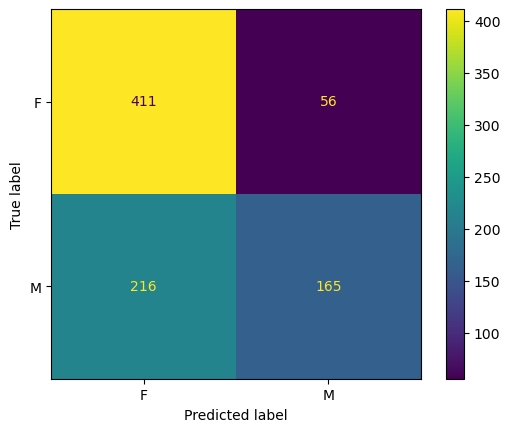

In [46]:
#Hacemos las predicciones para evaluar el modelo
y_pred = svm_poly_bal.predict(X_val)

#Evaluamos el modelo
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator( svm_poly_bal, X_val, y_val, values_format='d')
print(classification_report(y_val, y_pred))

#### 4.1.2 Polinomial Balanceado y óptimo

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


# Rango de C en escala logarítmica
C_values = np.logspace(-3, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Modelo base con parámetros fijos excepto C
svm_poly_bal_C = SVC(
    kernel="poly", degree=3, coef0=10, probability=True,
    class_weight="balanced"
)

# Grid Search solo sobre C
param_grid = {'C': C_values}

grid_search = GridSearchCV(
    estimator=svm_poly_bal_C,
    param_grid=param_grid,
    scoring='f1_weighted',  # Para clases desbalanceada
    cv=5,
    n_jobs=-1
)

# Entrenamiento
grid_search.fit(X_train, y_train)


# Resultados
print("Mejor valor de C:", grid_search.best_params_['C'])
print("Mejor score:", grid_search.best_score_)

Mejor valor de C: 1000.0
Mejor score: 0.6983363487340701


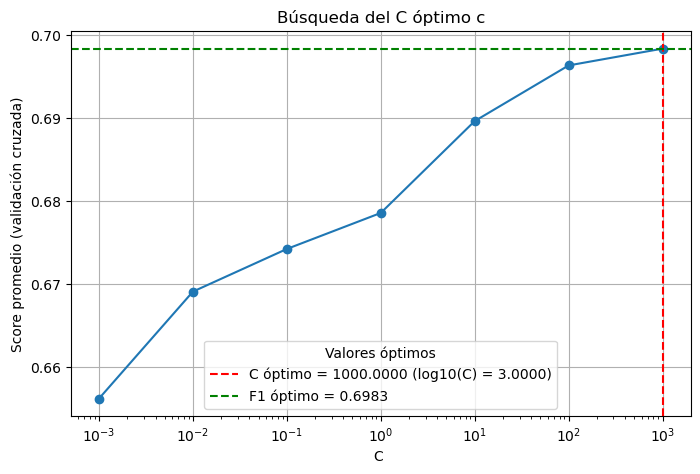

In [48]:
# Extraer todos los resultados
resultados = pd.DataFrame(grid_search.cv_results_)

# Mejor valor de C y F1 Score
C_optimo = grid_search.best_params_['C']
f1_optimo = grid_search.best_score_
log_C_optimo = np.log10(C_optimo)


# Graficar
plt.figure(figsize=(8, 5))
plt.semilogx(resultados['param_C'].astype(float), resultados['mean_test_score'], marker='o')

# Líneas guía
plt.axvline(x=C_optimo, color='red', linestyle='--', label=f'C óptimo = {C_optimo:.4f} (log10(C) = {log_C_optimo:.4f})')

plt.axhline(y=f1_optimo, color='green', linestyle='--', label=f'F1 óptimo = {f1_optimo:.4f}')

# Leyenda 
plt.legend(title='Valores óptimos', loc='best')
            
plt.xlabel('C ')
plt.ylabel('Score promedio (validación cruzada)')
plt.title("Búsqueda del C óptimo c")
plt.grid(True)
plt.show()

In [49]:
#Modelo optimizado y balanceado
svm_poly_bal_C = SVC(
    kernel="poly", degree=3, coef0=10, probability=True, C= 1000,
    class_weight="balanced"
)
svm_poly_bal_C.fit(X_train, y_train)

SVC(C=1000, class_weight='balanced', coef0=10, kernel='poly', probability=True)

In [50]:
# Realizar predicciones en el conjunto de validación y prueba
y_val_pred = svm_poly_bal_C.predict(X_val)
y_test_pred = svm_poly_bal_C.predict(X_test)

#Evaluacion del modelo
df_val = pd.DataFrame(classification_report(y_val, y_val_pred, output_dict=True)).transpose()
df_test = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).transpose()

Reporte de clasificación - Validación
              precision  recall  f1-score  support
F                 0.717   0.754     0.735    467.0
M                 0.678   0.635     0.656    381.0
accuracy          0.700   0.700     0.700      0.7
macro avg         0.697   0.694     0.695    848.0
weighted avg      0.699   0.700     0.699    848.0

Reporte de clasificación - Prueba
              precision  recall  f1-score  support
F                 0.762   0.721     0.741  480.000
M                 0.660   0.707     0.682  368.000
accuracy          0.715   0.715     0.715    0.715
macro avg         0.711   0.714     0.712  848.000
weighted avg      0.718   0.715     0.716  848.000


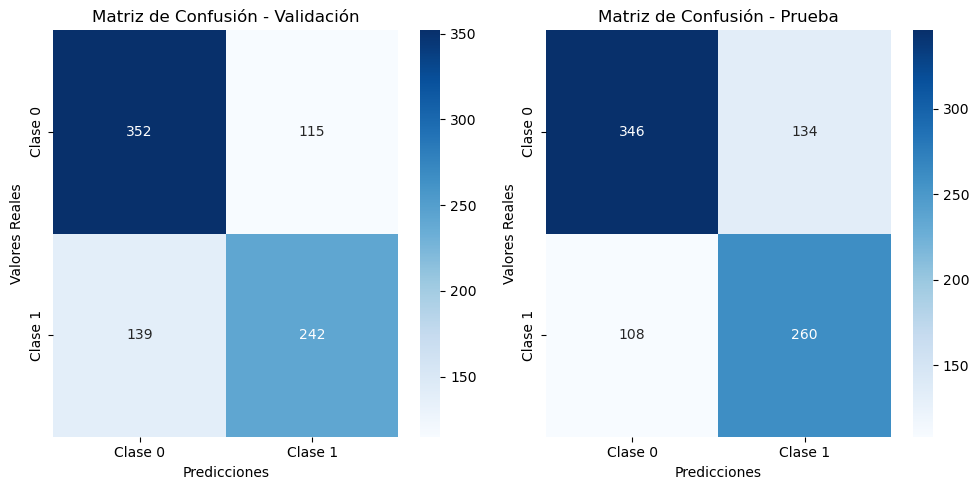

In [51]:
#Evaluacion

# Mostrar tablas con solo 3 decimales
print("Reporte de clasificación - Validación")
print(df_val.round(3))

print("\nReporte de clasificación - Prueba")
print(df_test.round(3))

# Matrices de confusión
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Mostrar las matrices de confusión
plt.figure(figsize=(10, 5))

# Matriz de confusión para validación
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión - Validación')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')

# Matriz de confusión para prueba
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')

plt.tight_layout()
plt.show()

<p data-start="178" data-end="549"><strong>Conclusi&oacute;n:&nbsp;</strong></p>
<p data-start="551" data-end="879">En el conjunto de validaci&oacute;n, el modelo alcanz&oacute; una exactitud del 70%, con un desempe&ntilde;o ligeramente mejor en la clase "F" (precisi&oacute;n: 0.717, recall: 0.754) que en la clase positiva "M" (precisi&oacute;n: 0.678, recall: 0.635). Este desequilibrio indica que el modelo tiende a clasificar mejor los casos de la clase mayoritaria.</p>
<p data-start="881" data-end="1344">En el conjunto de prueba, se observ&oacute; una ligera mejora en la exactitud general, alcanzando 71.5%, y un mejor equilibrio entre ambas clases. La clase "F" mantuvo un buen desempe&ntilde;o (precisi&oacute;n: 0.762, recall: 0.721), mientras que la clase "M" mejor&oacute; su recall a 0.707, aunque con una ligera ca&iacute;da en precisi&oacute;n (0.660). Esto sugiere que el modelo generaliza razonablemente bien a datos no vistos, especialmente considerando el desbalance natural entre clases.</p>
<p data-start="1346" data-end="1578">Las matrices de confusi&oacute;n muestran que a&uacute;n se presentan errores de clasificaci&oacute;n, principalmente confundiendo instancias de la clase "M" como "F", pero el uso del par&aacute;metro class_weight='balanced' ha ayudado a mitigar este efecto.</p>
<p data-start="1580" data-end="1792">En resumen, el modelo SVM polinomial balanceado ofrece un rendimiento aceptable y generaliza con estabilidad, siendo adecuado para escenarios donde se busca un compromiso entre precisi&oacute;n y recall en ambas clases.</p>